# Analyzing Investment Returns with Monte Carlo Simulations

## The Problem

We have \\$1,000 now and need to pay \\$1,050 in one year. We have
available two assets: a risk free asset that returns 3%, and a stock
that returns 10% with a 20% standard deviation. How much should we
invest in the two assets to maximize our probability of having at least
\\$1,050 in one year?

## The Basic Model

We should first build the model which handles a single set of inputs to produce a single set of outputs. Once that is working correctly, then we can run Monte Carlo simulations using the model.

In this model, we will want to build it for a given return for each of the assets. Then later we can bring in the standard deviations by drawing the returns from normal distributions in the simulations.

### Portfolio Returns

We need to determine the returns on the portfolio. It matters what weights we have invested in each of the assets, as well as each of the asset's returns.

This is just a one period model, so the portfolio return is $r_p = r_{rf} w_{rf} + r_s w_s$

This can be simplified even further. There are only two assets, and we will be fully invested, so $w_{rf} + w_s = 1$, therefore $w_{rf} = 1 - w_s$ and we can just eliminate the $w_{rf}$, yielding:

$r_p = r_{rf} (1 - w_s) + r_s w_s$

In [1]:
stock_ret = 0.1
rf = 0.03
stock_weight = 0.5

portfolio_ret = rf * (1 - stock_weight) + stock_ret * stock_weight
portfolio_ret

0.065

Now let's apply that return to the initial portfolio value to get the final portfolio value.

In [2]:
portfolio_initial_value = 1000

portfolio_end_value = portfolio_initial_value * (1 + portfolio_ret)
portfolio_end_value

1065.0

Now let's wrap this up into one function that will represent our model.

In [3]:
def port_end_value(stock_ret=0.1, rf=0.03, stock_weight=0.5, portfolio_initial_value=1000):
    portfolio_ret = rf * (1 - stock_weight) + stock_ret * stock_weight
    portfolio_end_value = portfolio_initial_value * (1 + portfolio_ret)
    return portfolio_end_value

port_end_value()

1065.0

It works for the initial inputs, also trying with other inputs.

In [4]:
port_end_value(0.05, 0.03, 0.7)

1044.0

So it seems our model function is working correctly.

## Monte Carlo Simulations

So now we know that if we earn 10% on the stock and invest 50% in it, we will have enough money. We also know if it returns only 5%, it's not going to be enough to meet our required \$1,050. But we don't know anything about the probability of having enough money.

To run a Monte Carlo simulation, all we do is assign distributions as necessary to any inputs, then run the model a bunch of times, drawing inputs from the distributions, passing them into the model, and collecting the outputs.

### Draw Inputs From Distributions

So here, we are only concerned with assigning the stock return to a distribution. We will not vary the risk free rate as it has a standard deviation of zero, so it would always be the same value anyway. We will not vary the weight as that is a decision variable. We will not vary the inital portfolio value as it shouldn't change.

We will assume that the stock's returns are normally distributed. Let's try to pull a single return from the normal distribution for this stock.

In [5]:
import random

stock_mean = 0.1
stock_std = 0.2

random.normalvariate(stock_mean, stock_std)

0.0952728219262988

We can run the above cell multiple times to see that it will choose a different return each time. This is what we need to pass into our model each time.

### Run the Model

Now rather than taking stock return as fixed, let's run the model using the randomly drawn stock return.

In [6]:
stock_ret = random.normalvariate(stock_mean, stock_std)
print(f'running with stock return {stock_ret:.1%}')
port_end_value(stock_ret)

running with stock return 36.8%


1199.0611582278914

We can run the above cell multiple times to see that we will get a different portfolio end value each time.

### Collect the Outputs

All we need to do here is run the above steps in a loop, appending the result to a list each time we run the model. This is especially simple because we only have one output from the model. If we have multiple outputs from a single run of our model, we will have to use some other data structure, such as multiple lists, a list of lists, a list of dictionaries, or a `DataFrame`.

In [7]:
n_iter = 3
outputs = []
for i in range(n_iter):
    stock_ret = random.normalvariate(stock_mean, stock_std)
    result = port_end_value(stock_ret)
    outputs.append(result)
outputs

[1045.2705049773215, 1168.3949220520244, 1076.4933461374005]

### Create a Function for This

Now just put it all together into a function. I will also allow passing of different stock weights in the function.

In [8]:
def port_end_value_simulations(stock_mean=0.1, stock_std=0.2, stock_weight=0.5, n_iter=1000):
    outputs = []
    for i in range(n_iter):
        stock_ret = random.normalvariate(stock_mean, stock_std)
        result = port_end_value(stock_ret, stock_weight=stock_weight)
        outputs.append(result)
    return outputs

results = port_end_value_simulations()
print(f'There are {len(results)} results. First five:')
results[:5]

There are 1000 results. First five:


[1008.9819197941039,
 1157.0983339293448,
 1034.148919449114,
 1117.3893622696037,
 1015.4106314279522]

## Analyze the Outputs

### Visualize

Usually a first good way to analyze the outputs is to visualize them. Let's plot the results. A histogram or KDE plot is usually most appropriate for visualizing a single output. The KDE is basically a smoothed out histogram.

<AxesSubplot:ylabel='Frequency'>

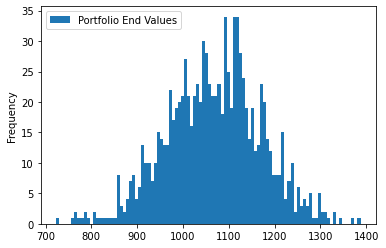

In [9]:
%matplotlib inline
import pandas as pd

df = pd.DataFrame()
df['Portfolio End Values'] = results
df.plot.hist(bins=100)

<AxesSubplot:ylabel='Density'>

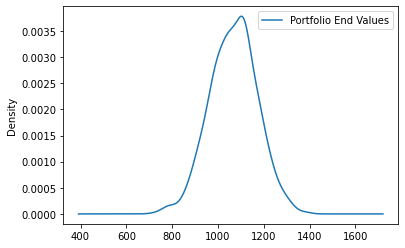

In [10]:
df.plot.kde()

As we can see, the results look basically like a normal distribution. Which makes sense because we only have one input changing and it is following a normal distribution.

### Probability Outputs

#### Probability Table

We would like to see two other kinds of outputs. One is a table of probabilities, along with the result which is achived at that probability in the distribution. E.g. at 5%, only 5% of cases are lower than the given value. At 75%, 75% of cases are lower than the given value.

First we'll get the percentiles we want to explore in the table.

In [11]:
percentiles = [i/20 for i in range(1, 20)]
percentiles

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

Now we can use the `.quantile` method from `pandas` to get this table easily. 

In [12]:
df['Portfolio End Values'].quantile(percentiles)

0.05     899.667812
0.10     935.611907
0.15     961.836436
0.20     981.017481
0.25     998.910525
0.30    1011.133976
0.35    1028.926613
0.40    1043.666677
0.45    1055.441709
0.50    1070.911963
0.55    1086.829135
0.60    1097.522795
0.65    1111.747250
0.70    1121.199232
0.75    1133.906056
0.80    1153.423863
0.85    1173.427836
0.90    1194.409368
0.95    1233.687254
Name: Portfolio End Values, dtype: float64

#### Probability of Acheiving Objective

The other kind of output is the probability that we will achieve our objective. Here we want \\$1,050. So we want to find the probability we will have at least that much money. We can see from the prior table that the probability of getting a value lower than about \\$1,050 is 45%, so then the probability of getting at least \\$1,050 would be $1 - p$ or about 55%. But we want to get to that directly rather than using the table as the tables values might not line up well with our desired value.

There's not a direct `pandas` function for this. But as having more money still meets the objective, what we want to calculate is basically the percentage of observations that have a value equal to or higher than our desired objective.

In [13]:
( df['Portfolio End Values'] >= 1050 ).astype(int).mean()

0.572

The above one-liner achieves this. Let's break it down. First we are comparing each portfolio end value to \\$1,050. We will have a `Series` of boolean values for whether the original value was greater than \\$1,050.

In [14]:
df['Portfolio End Values'] >= 1050

0      False
1       True
2      False
3       True
4      False
       ...  
995    False
996     True
997     True
998     True
999     True
Name: Portfolio End Values, Length: 1000, dtype: bool

We then convert those booleans to integers.

In [15]:
( df['Portfolio End Values'] >= 1050 ).astype(int)

0      0
1      1
2      0
3      1
4      0
      ..
995    0
996    1
997    1
998    1
999    1
Name: Portfolio End Values, Length: 1000, dtype: int64

Now we have 1 when it is greater, and 0 otherwise. So the average of this will produce the probability.

### Putting the Visualization and Probabilities Together

We just want to wrap this up into a few functions, to make it easier to run for the next step.

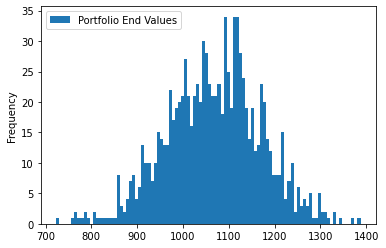

Probability Table
0.05     $899.67
0.10     $935.61
0.15     $961.84
0.20     $981.02
0.25     $998.91
0.30    $1011.13
0.35    $1028.93
0.40    $1043.67
0.45    $1055.44
0.50    $1070.91
0.55    $1086.83
0.60    $1097.52
0.65    $1111.75
0.70    $1121.20
0.75    $1133.91
0.80    $1153.42
0.85    $1173.43
0.90    $1194.41
0.95    $1233.69
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 57.2%



In [16]:
import matplotlib.pyplot as plt

def create_dataframe_from_results(results):
    df = pd.DataFrame()
    df['Portfolio End Values'] = results
    return df


def visualize_results(df):
    df.plot.hist(bins=100)
    plt.show()  # makes plot show right now, which we will need when running this multiple times


def probability_table(df):
    percentiles = [i/20 for i in range(1, 20)]
    return df['Portfolio End Values'].quantile(percentiles)


def probability_of_objective(df, desired_cash=1050):
    return ( df['Portfolio End Values'] >= desired_cash ).astype(int).mean()


def model_outputs(results, desired_cash=1050):
    df = create_dataframe_from_results(results)
    visualize_results(df)
    prob_table = probability_table(df)
    prob_objective = probability_of_objective(df, desired_cash=desired_cash)
    return prob_table, prob_objective


def display_model_summary(results, desired_cash=1050):
    prob_table, prob_objective = model_outputs(results, desired_cash=desired_cash)
    print('Probability Table')
    print(prob_table.apply(lambda x: f'${x:.2f}'))  # a way of formatting a pandas series
    print('')
    print(f'Probability of getting ${desired_cash:,.0f} in cash: {prob_objective:.1%}')
    print('')
    
    
display_model_summary(results)

## Choosing an Appropriate Weight

Now we have our full model and Monte Carlo simulation set up. We want to use it to decide what weight to invest in the stock versus the risk free asset. Therefore we will run the full model outputs through the simulation for a bunch of different weights.

### A Quick Aside to Formatting

However it will start getting difficult to tell which weight's section we are in because there are so many outputs. So let's add a bit more formatting as well. In Jupyter we can directly display HTML. So let's write a little utility function to display a header in our output.

In [17]:
from IPython.display import HTML, display
display(HTML('<h2>My Title</h2>'))

The above title is being generated by the code and not a special markdown cell. `h2` is a second-level header in HTML. We just wrap what we want in the `h2` tags. Here's a general function which can add a header for us.

In [18]:
def display_header(header):
    return display(HTML(f'<h2>{header}</h2>'))

display_header('Another Title')

### Back to Choosing an Appropriate Weight

We want to evaluate weights from 10% to 90% in 10% increments:

In [19]:
weights = [i/10 for i in range(1, 10)]
weights

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

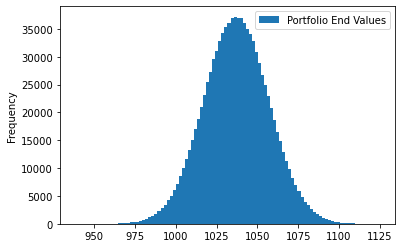

Probability Table
0.05    $1004.10
0.10    $1011.38
0.15    $1016.31
0.20    $1020.20
0.25    $1023.54
0.30    $1026.54
0.35    $1029.32
0.40    $1031.96
0.45    $1034.51
0.50    $1037.03
0.55    $1039.55
0.60    $1042.09
0.65    $1044.74
0.70    $1047.51
0.75    $1050.50
0.80    $1053.86
0.85    $1057.74
0.90    $1062.65
0.95    $1069.88
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 25.8%



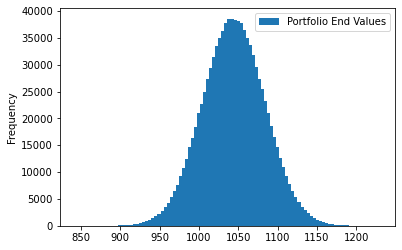

Probability Table
0.05     $978.30
0.10     $992.75
0.15    $1002.53
0.20    $1010.38
0.25    $1017.11
0.30    $1023.09
0.35    $1028.68
0.40    $1033.97
0.45    $1039.02
0.50    $1044.03
0.55    $1049.08
0.60    $1054.18
0.65    $1059.46
0.70    $1065.04
0.75    $1071.03
0.80    $1077.77
0.85    $1085.58
0.90    $1095.35
0.95    $1109.82
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 44.1%



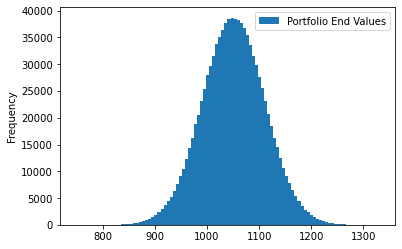

Probability Table
0.05     $952.31
0.10     $974.29
0.15     $988.90
0.20    $1000.55
0.25    $1010.55
0.30    $1019.55
0.35    $1027.91
0.40    $1035.85
0.45    $1043.49
0.50    $1051.02
0.55    $1058.60
0.60    $1066.27
0.65    $1074.14
0.70    $1082.46
0.75    $1091.52
0.80    $1101.55
0.85    $1113.16
0.90    $1127.92
0.95    $1149.74
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 50.7%



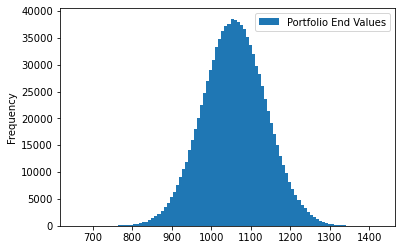

Probability Table
0.05     $926.25
0.10     $955.45
0.15     $975.10
0.20     $990.69
0.25    $1004.12
0.30    $1016.08
0.35    $1027.16
0.40    $1037.68
0.45    $1047.92
0.50    $1057.94
0.55    $1068.02
0.60    $1078.26
0.65    $1088.79
0.70    $1099.95
0.75    $1112.07
0.80    $1125.42
0.85    $1140.99
0.90    $1160.68
0.95    $1189.72
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 54.0%



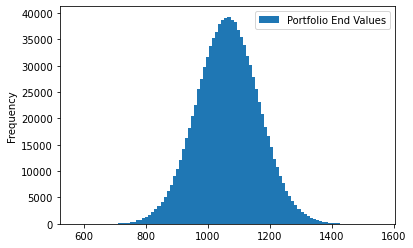

Probability Table
0.05     $899.99
0.10     $936.42
0.15     $961.07
0.20     $980.54
0.25     $997.24
0.30    $1012.25
0.35    $1026.21
0.40    $1039.54
0.45    $1052.28
0.50    $1064.82
0.55    $1077.34
0.60    $1090.06
0.65    $1103.30
0.70    $1117.26
0.75    $1132.32
0.80    $1148.98
0.85    $1168.52
0.90    $1193.16
0.95    $1229.50
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 55.9%



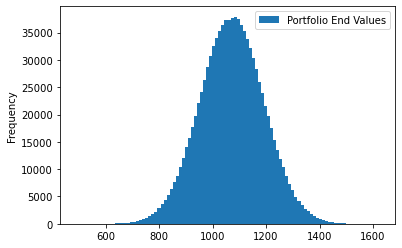

Probability Table
0.05     $874.79
0.10     $918.26
0.15     $947.79
0.20     $971.35
0.25     $991.21
0.30    $1009.09
0.35    $1025.75
0.40    $1041.64
0.45    $1056.95
0.50    $1072.19
0.55    $1087.25
0.60    $1102.39
0.65    $1118.17
0.70    $1134.80
0.75    $1152.73
0.80    $1172.73
0.85    $1196.19
0.90    $1225.61
0.95    $1269.35
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 57.3%



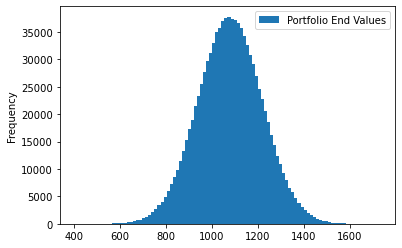

Probability Table
0.05     $848.38
0.10     $899.34
0.15     $933.61
0.20     $961.00
0.25     $984.48
0.30    $1005.69
0.35    $1025.12
0.40    $1043.58
0.45    $1061.34
0.50    $1078.91
0.55    $1096.61
0.60    $1114.48
0.65    $1132.81
0.70    $1152.27
0.75    $1173.31
0.80    $1196.70
0.85    $1224.04
0.90    $1258.13
0.95    $1309.29
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 58.2%



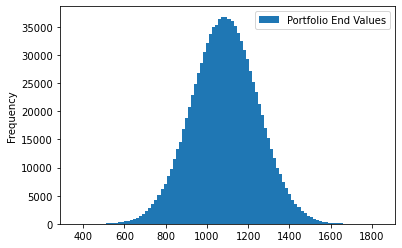

Probability Table
0.05     $823.00
0.10     $881.12
0.15     $920.30
0.20     $951.46
0.25     $978.34
0.30    $1002.37
0.35    $1024.66
0.40    $1045.77
0.45    $1066.20
0.50    $1086.31
0.55    $1106.42
0.60    $1126.85
0.65    $1147.99
0.70    $1170.27
0.75    $1194.22
0.80    $1220.93
0.85    $1251.95
0.90    $1290.94
0.95    $1349.18
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 59.0%



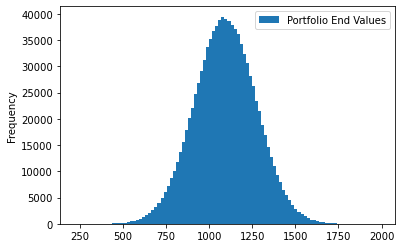

Probability Table
0.05     $796.94
0.10     $862.65
0.15     $906.78
0.20     $942.00
0.25     $972.06
0.30     $998.84
0.35    $1023.84
0.40    $1047.48
0.45    $1070.37
0.50    $1092.85
0.55    $1115.50
0.60    $1138.56
0.65    $1162.31
0.70    $1187.26
0.75    $1214.41
0.80    $1244.28
0.85    $1279.18
0.90    $1323.23
0.95    $1388.68
Name: Portfolio End Values, dtype: object

Probability of getting $1,050 in cash: 59.5%



In [21]:
for weight in weights:
    display_header(f'Results with {weight:.0%} in the Stock')
    results = port_end_value_simulations(stock_weight=weight, n_iter = 1000000)
    display_model_summary(results)

## Conclusions

We got sort of an unintuitive outcome, which we wouldn't have thought about without going through such an exercise. It turns out the the probability of reaching our desired cash starts out to be increasing with the weight in the stock, but with 50% in the stock and higher it is relatively stable. What is mainly changing beyond that point is the extreme outcomes. With a higher weight in the stock, it is more likely to earn more money on the top end, but also to lose more money on the bottom end. So it depends on the manager's risk tolerance which stock weight should be picked, but likely lower than 50% in the stock would be a bad choice due to lower probability of hitting the objective. 